# Aim

Experiment with Extended Kalman smoothing for transit parameters.

In [26]:
import batman
import lightkurve as lk
import numpy as np
import copy
import os
from matplotlib import pyplot as plt

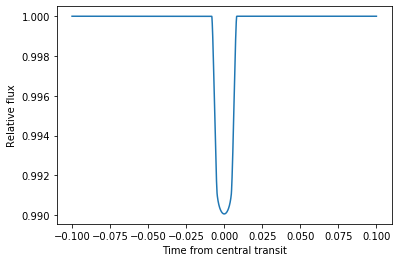

In [2]:
# the basic example from the batman docs, just for testing
params = batman.TransitParams()
params.t0 = 0.                       #time of inferior conjunction
params.per = 1.                      #orbital period
params.rp = 0.1                      #planet radius (in units of stellar radii)
params.a = 15.                       #semi-major axis (in units of stellar radii)
params.inc = 87.                     #orbital inclination (in degrees)
params.ecc = 0.                      #eccentricity
params.w = 90.                       #longitude of periastron (in degrees)
params.u = [0.93, -0.23, 0, 0]      #limb darkening coefficients [u1-u4]
params.limb_dark = "nonlinear"       #limb darkening model
t = np.linspace(-0.1, 0.1, 10000)
m = batman.TransitModel(params, t)    #initializes model
flux = m.light_curve(params)          #calculates light curve
plt.plot(t, flux)
plt.xlabel("Time from central transit")
plt.ylabel("Relative flux")
plt.show()

In [3]:
# the Extended Kalman Filter

eps = 1e-6

def jacobian(f, p):
    '''
    Finds the Jacobian matrix of the function f at the point p.
    
    Arguments
    ---------
    f : callable
    A function F^n -> F^m (F = R usually but not assumed); 
    takes in an n-length numpy array and returns an m-length numpy array.
    
    p : np.ndarray, shape (n,)
    The n-length numpy array around which we want to approximate the Jacobian.
    
    Returns
    -------
    jac : np.ndarray, shape (m, n)
    The Jacobian matrix (the matrix of first-order partial derivatives).
    '''
    n = len(p)
    center = f(p)
    rights = f(p + eps * np.eye(n))
    lefts = f(p - eps * np.eye(n))
    return .5 * ((rights.T - center) / eps + (center - lefts.T) / eps).T

class EKFilter():
    def __init__(self, f, Q, h, R, state=None):
        self.f = f
        self.Q = Q
        self.h = h
        self.R = R
        self.s = Q.shape[0]
        self.m = R.shape[0]
        if state is None:
            self.state = np.zeros(self.s)
        else:
            self.state = state
        self.prev_P = np.zeros((self.s, self.s))
        self.P = np.zeros((self.s, self.s))
    
    def predict(self):
        self.prev_P = copy.deepcopy(self.P)
        if isinstance(self.f, np.ndarray):
            self.state = self.f @ self.state
            self.P = self.f @ self.P @ self.f + self.Q
        else:
            A = jacobian(self.f, self.state)
            self.state = self.f(self.state)
            self.P = A @ self.P @ A + self.Q
        
    def update(self, measurement):
        if isinstance(self.h, np.ndarray):
            C = jacobian(self.h, self.state)
            innovation = measurement - self.h(self.state)
        else:
            C = self.h
            innovation = measurement - self.h @ self.state
        if not self.steady_state:
            self.K = self.P @ C.T @ np.linalg.inv(C @ self.P @ C.T + self.R)
            self.P -= self.K @ (C @ self.P)
            if np.allclose(self.P, self.prev_P):
                self.steady_state = True
        innovation = measurement - C @ self.state
        self.state = self.state + self.K @ innovation

In [56]:
# EKF functions for the light curve

def get_a(period, mstar, Go4pi=2945.4625385377644/(4*np.pi*np.pi)):
    """
    https://dfm.io/posts/exopop/
    Compute the semi-major axis of an orbit in Solar radii.
    
    :param period: the period in days
    :param mstar:  the stellar mass in Solar masses
    
    """
    return (Go4pi*period*period*mstar) ** (1./3)

dt = 30 / (60 * 60 * 24) # 30 minute cadence in days
mstar = 1.
params = batman.TransitParams()
params.t0 = 0.
params.per = 1.
params.rp = 0.1
params.a = get_a(params.per, mstar)
params.inc = 87.
params.ecc = 0.
params.w = 90.                      #longitude of periastron (in degrees)
params.u = [0.93, -0.23, 0, 0]      #limb darkening coefficients [u1-u4]
params.limb_dark = "nonlinear"       #limb darkening model
t = np.arange(0, params.per + dt, dt)
m = batman.TransitModel(params, t)
fluxes = m.light_curve(params)
err_flux = m.calc_err() / 1e6

def batman_to_partial_state(params):
    state = np.array([
        params.per,
        params.rp,
        params.inc,
        params.ecc,
        params.w
    ])
    state = np.concatenate((state, params.u))
    return state

def recompute_lightcurve(state):
    global params, fluxes
    params.per, params.rp, params.inc, params.ecc, params.w = state[2:7]
    params.a = get_a(params.per, mstar)
    params.u = state[7:]
    fluxes = m.light_curve(params)
    return fluxes

def lightcurve_state_transition(state):
    '''
    Takes in a state: [flux, t_idx, period, prad, incl, ecc, omega, *limbdark1-4].
    Returns the state at the next timestep.
    '''
    if len(state.shape) > 1:
        # passing in an array from the Jacobian
        return np.vstack((lightcurve_state_transition(row) for row in state))
    if not np.allclose(batman_to_partial_state(params), state[2:]):
        # the Kalman update did something that'll need to be changed in the light curve
        recompute_lightcurve(state)
    state[1] = (state[1] + 1) % len(t) # time index
    state[0] = fluxes[int(state[1])]
    return state

def lightcurve_measure(state):
    return state[0] # and PRFs and stuff later

# add in a discretization error term

Q = np.diag([
    err_flux, # var(flux) = variance of batman model flux + inherent variance
    0, # time index: no error. 
    eps, # var(period) between timesteps, should be small
    eps, # var(prad)
    eps, # var(inc)
    eps, # var(ecc)
    eps, # var(omega)
    *[eps] * len(params.u) # var(limbdarks)
])

R = np.array([[eps]]) # to be replaced by PRF stuff

In [53]:
# time to pick a TOI or KOI!
star_id = "KIC11446443"
if os.path.exists("flux_{}.npy".format(star_id)):
    lc_time, lc_flux = np.load("time_{}.npy".format(star_id)), np.load("flux_{}.npy".format(star_id))
else:
    pixelfile = lk.search_targetpixelfile(star_id, quarter=1).download(quality_bitmask='hardest')
    lc = pixelfile.to_lightcurve(aperture_mask='all')
    lc_time, lc_flux = lc.time, lc.flux
    np.save("time_{}.npy".format(star_id), lc_time)
    np.save("flux_{}.npy".format(star_id), lc_flux)


# TIC Contamination Ratio	0.05501

In [62]:
lightcurve_filter = EKFilter(f=lightcurve_state_transition, Q=Q, h=lightcurve_measure, R=R, state=np.array([
    lc_flux[0],
    0,
    2.4706,
    13.04,
    90.,
    0.,
    0.,
    *[1.,0.,0.,0.]
], dtype=np.float64))

lightcurve_filter.predict()
lightcurve_filter.state